# Image generation with Würstchen and OpenVINO
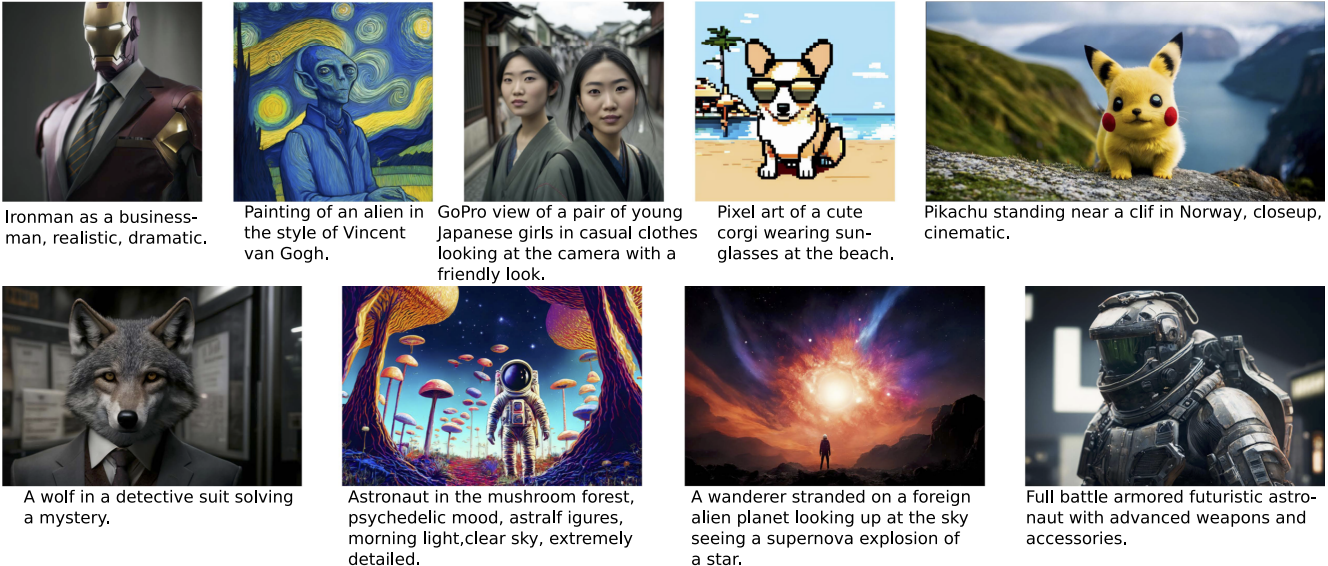
Würstchen is a diffusion model, whose text-conditional model works in a highly compressed latent space of images. Why is this important? Compressing data can reduce computational costs for both training and inference by magnitudes. Training on 1024x1024 images, is way more expensive than training at 32x32. Usually, other works make use of a relatively small compression, in the range of 4x - 8x spatial compression. Würstchen takes this to an extreme. Through its novel design, authors achieve a 42x spatial compression. This was unseen before because common methods fail to faithfully reconstruct detailed images after 16x spatial compression. Würstchen employs a two-stage compression, what we call Stage A and Stage B. Stage A is a VQGAN, and Stage B is a Diffusion Autoencoder (more details can be found in the [paper](https://arxiv.org/abs/2306.00637)). A third model, Stage C, is learned in that highly compressed latent space. This training requires fractions of the compute used for current top-performing models, allowing also cheaper and faster inference.

We will use PyTorch version of Würstchen [model from HuggingFace Hub](https://huggingface.co/warp-ai/wuerstchen).
### Table of content:
- [Prerequisites](#Prerequisites-Uparrow)
- [Load the original model](#Load-the-original-model-Uparrow)
    - [Infer the original model](#Infer-the-original-model-Uparrow)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR-Uparrow)
    - [Prior pipeline](#Prior-pipeline-Uparrow)
    - [Decoder pipeline](#Decoder-pipeline-Uparrow)
- [Compiling models](#Compiling-models-Uparrow)
- [Building the pipeline](#Building-the-pipeline-Uparrow)
- [Interactive inference](#Interactive-inference-Uparrow)


## Prerequisites [$\Uparrow$](#Table-of-content:)


In [1]:
%pip install -q  "diffusers>=0.21.0" transformers accelerate matplotlib gradio


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip install -q "openvino==2023.1"

In [3]:
%pip install "http://ov-share-03.iotg.sclab.intel.com/volatile/openvino_ci/private_builds/dldt/master/pre_commit/d8349b27f5ede0897f25b7679849ad5adf9d8c87/private_linux_ubuntu_20_04_release/wheels/openvino-2023.2.0.dev20231010-12744-cp310-cp310-manylinux_2_31_x86_64.whl"

  ERROR: HTTP error 404 while getting http://ov-share-03.iotg.sclab.intel.com/volatile/openvino_ci/private_builds/dldt/master/pre_commit/d8349b27f5ede0897f25b7679849ad5adf9d8c87/private_linux_ubuntu_20_04_release/wheels/openvino-2023.2.0.dev20231010-12744-cp310-cp310-manylinux_2_31_x86_64.whl
ERROR: Could not install requirement openvino==2023.2.0.dev20231010 from http://ov-share-03.iotg.sclab.intel.com/volatile/openvino_ci/private_builds/dldt/master/pre_commit/d8349b27f5ede0897f25b7679849ad5adf9d8c87/private_linux_ubuntu_20_04_release/wheels/openvino-2023.2.0.dev20231010-12744-cp310-cp310-manylinux_2_31_x86_64.whl because of HTTP error 404 Client Error: Not Found for url: http://ov-share-03.iotg.sclab.intel.com/volatile/openvino_ci/private_builds/dldt/master/pre_commit/d8349b27f5ede0897f25b7679849ad5adf9d8c87/private_linux_ubuntu_20_04_release/wheels/openvino-2023.2.0.dev20231010-12744-cp310-cp310-manylinux_2_31_x86_64.whl for URL http://ov-share-03.iotg.sclab.intel.com/volatile/openv

In [4]:
from pathlib import Path
from typing import Optional, List, Union, Callable
from collections import namedtuple
import gc

import diffusers
import torch
import matplotlib.pyplot as plt
import gradio as gr
import numpy as np

import openvino as ov

In [5]:
MODELS_DIR = Path("models")
PRIOR_TEXT_ENCODER_PATH = MODELS_DIR / "prior_text_encoder.xml"
PRIOR_PRIOR_PATH = MODELS_DIR / "prior_prior.xml"
DECODER_PATH = MODELS_DIR / "decoder.xml"
TEXT_ENCODER_PATH = MODELS_DIR / "text_encoder.xml"
VQGAN_PATH = MODELS_DIR / "vqgan.xml"

MODELS_DIR.mkdir(parents=True, exist_ok=True)

## Load the original model [$\Uparrow$](#Table-of-content:)
We use `from_pretrained` method of `diffusers.AutoPipelineForText2Image` to load the pipeline.

In [6]:
pipeline = diffusers.AutoPipelineForText2Image.from_pretrained("warp-diffusion/wuerstchen")

/home/itrushkin/.virtualenvs/wuerstchen/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded model has `WuerstchenCombinedPipeline` type and consists of 2 parts: prior and decoder.

### Infer the original model [$\Uparrow$](#Table-of-content:)


In [7]:
caption = "Anthropomorphic cat dressed as a fire fighter"
negative_prompt = ""
num_images_per_prompt = 1

output = pipeline(
    prompt=caption,
    height=1024,
    width=1024,
    negative_prompt=negative_prompt,
    prior_guidance_scale=4.0,
    decoder_guidance_scale=0.0,
    num_images_per_prompt=num_images_per_prompt,
    output_type="pil",
).images

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

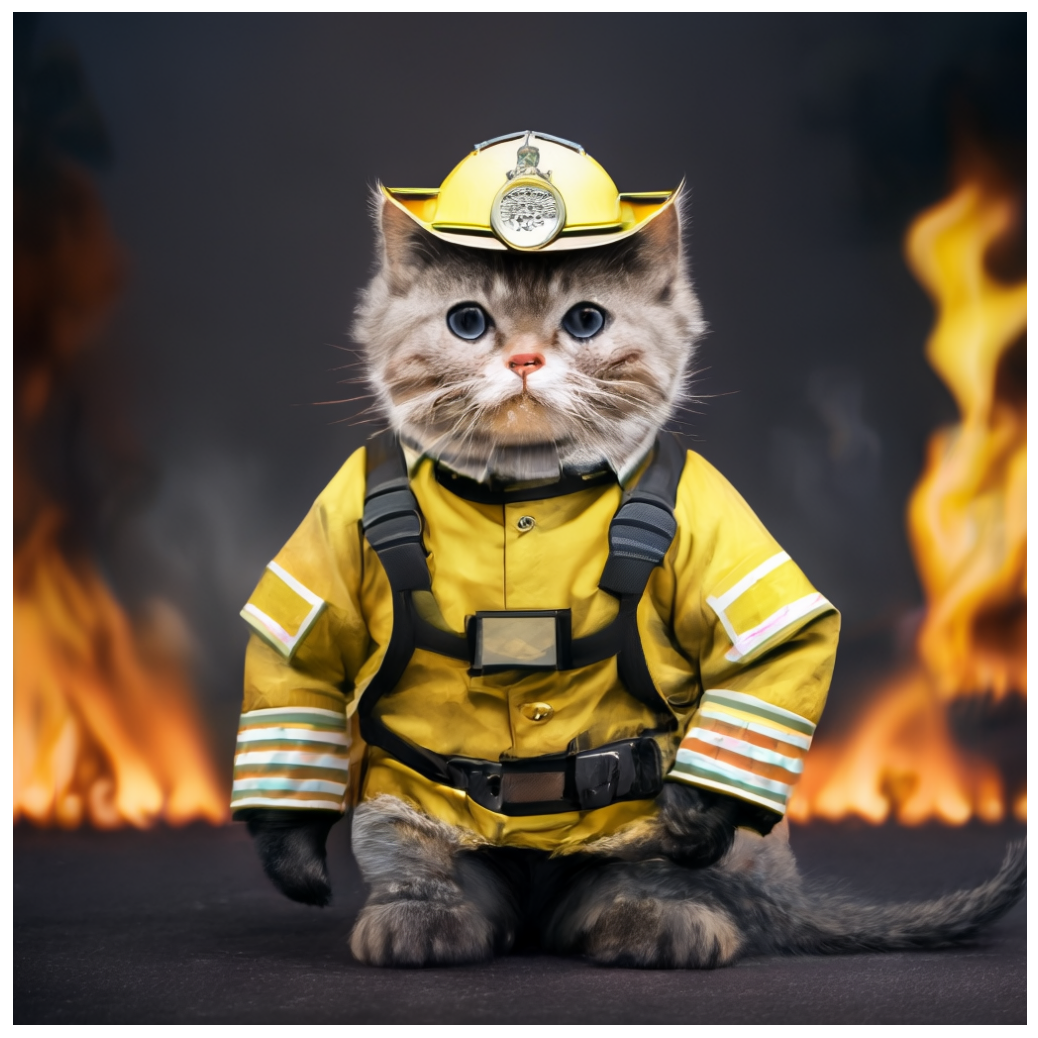

In [8]:
plt.figure(figsize=(8 * len(output), 8), dpi=128, layout="compressed")
for i, x in enumerate(output):
    plt.subplot(1, len(output), i + 1)
    plt.imshow(x)
    plt.axis("off")

## Convert the model to OpenVINO IR [$\Uparrow$](#Table-of-content:)
Model inference has the following architecture:

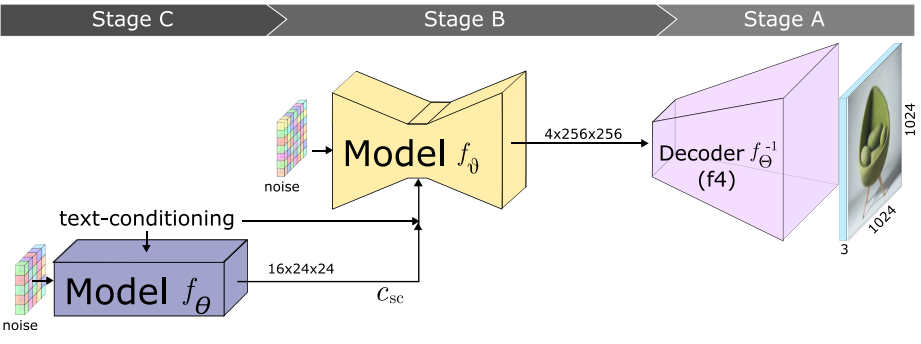

Main model components:
- Stage C: create low-dimensional latent space representation of the image using text-conditional LDM
- Stage B: using representation from Stage C, produce a latent image in latent space of higher dimensionality using another LDM 
- Stage A: using VQGAN-decoder, decode the latent image to yield a full-resolution output image

First, let's extract required pipeline components (PyTorch modules, tokenizers and schedulers) to free up the memory taken by the loaded pipeline. The pipeline consists of 2 sub-pipelines: Prior pipeline (Stage C) accessed by `prior_pipe` property, and Decoder Pipeline (Stages B & A) accessed by `decoder_pipe` property.

In [9]:
prior_text_encoder = pipeline.prior_text_encoder
prior_text_encoder.eval()
prior_prior = pipeline.prior_prior
prior_prior.eval()
decoder = pipeline.decoder
decoder.eval()
text_encoder = pipeline.text_encoder
text_encoder.eval()
vqgan = pipeline.vqgan
vqgan.eval()

tokenizer = pipeline.tokenizer
prior_tokenizer = pipeline.prior_tokenizer
scheduler = pipeline.scheduler
prior_scheduler = pipeline.prior_scheduler

del pipeline
gc.collect()

2239

Next, let's define the conversion function for PyTorch modules. We use `ov.convert_model` function to obtain OpenVINO Intermediate Representation object and `ov.save_model` function to save it as XML file.

In [10]:
def convert(model: torch.nn.Module, xml_path: Path, **convert_kwargs):
    if not xml_path.exists():
        converted_model = ov.convert_model(model, **convert_kwargs)
        ov.save_model(converted_model, xml_path, compress_to_fp16=False)
        del converted_model

        # Clean torch jit cache
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

        gc.collect()

### Prior pipeline [$\Uparrow$](#Table-of-content:)
This pipeline consists of text encoder and prior diffusion model. From here, we always use fixed shapes in conversion by using an `input` parameter to generate a less memory-demanding model.

Text encoder model has 2 inputs:
- `input_ids`: vector of tokenized input sentence. Default tokenizer vector length is 77.
- `attention_mask`: vector of same length as `input_ids` describing the attention mask.

In [11]:
convert(
    prior_text_encoder,
    PRIOR_TEXT_ENCODER_PATH,
    example_input={
        "input_ids": torch.zeros(1, 77, dtype=torch.int32),
        "attention_mask": torch.zeros(1, 77),
    },
    input={"input_ids": ((1, 77),), "attention_mask": ((1, 77),)},
)
del prior_text_encoder
gc.collect()

0

Prior model is the canonical unCLIP prior to approximate the image embedding from the text embedding. Like UNet, it has 3 inputs: sample, timestep and encoder hidden states.

In [12]:
convert(
    prior_prior,
    PRIOR_PRIOR_PATH,
    example_input=[torch.zeros(2, 16, 24, 24), torch.zeros(2), torch.zeros(2, 77, 1280)],
    input=[((2, 16, 24, 24),), ((2),), ((2, 77, 1280),)],
)
del prior_prior
gc.collect()

0

### Decoder pipeline [$\Uparrow$](#Table-of-content:)
Decoder pipeline consists of 3 parts: decoder, text encoder and VQGAN.

Decoder model is the WuerstchenDiffNeXt UNet decoder. Inputs are:
- `x`: sample
- `r`: timestep
- `effnet`: interpolation block
- `clip`: encoder hidden states

In [13]:
convert(
    decoder,
    DECODER_PATH,
    example_input={
        "x": torch.zeros(1, 4, 256, 256),
        "r": torch.zeros(1),
        "effnet": torch.zeros(1, 16, 24, 24),
        "clip": torch.zeros(1, 77, 1024),
    },
    input={
        "x": ((1, 4, 256, 256),),
        "r": ((1),),
        "effnet": ((1, 16, 24, 24),),
        "clip": ((1, 77, 1024),),
    },
)
del decoder
gc.collect()

0

Text encoder has the same parameters and shapes as text encoder in [prior pipeline](#Prior-pipeline).

In [14]:
convert(
    text_encoder,
    TEXT_ENCODER_PATH,
    example_input={
        "input_ids": torch.zeros(1, 77, dtype=torch.int32),
        "attention_mask": torch.zeros(1, 77),
    },
    input={"input_ids": ((1, 77),), "attention_mask": ((1, 77),)},
)
del text_encoder
gc.collect()

0

Pipeline uses VQGAN model `decode` method to get the full-size output image. Here we create the wrapper module for decoding part only. Our decoder takes as input 4x256x256 latent image.

In [15]:
class VqganDecoderWrapper(torch.nn.Module):
    def __init__(self, vqgan):
        super().__init__()
        self.vqgan = vqgan

    def forward(self, h):
        return self.vqgan.decode(h)

In [16]:
convert(
    VqganDecoderWrapper(vqgan),
    VQGAN_PATH,
    example_input=torch.zeros(1, 4, 256, 256),
    input=(1, 4, 256, 256),
)
del vqgan
gc.collect()

0

## Compiling models [$\Uparrow$](#Table-of-content:)


In [17]:
core = ov.Core()

In [18]:
ov_prior_text_encoder = core.compile_model(PRIOR_TEXT_ENCODER_PATH)

In [19]:
ov_prior_prior = core.compile_model(PRIOR_PRIOR_PATH)

In [20]:
ov_decoder = core.compile_model(DECODER_PATH)

In [21]:
ov_text_encoder = core.compile_model(TEXT_ENCODER_PATH)

In [22]:
ov_vqgan = core.compile_model(VQGAN_PATH)

## Building the pipeline [$\Uparrow$](#Table-of-content:)


In [23]:
class TextEncoderWrapper:
    dtype = torch.float32

    def __init__(self, text_encoder):
        self.text_encoder = text_encoder

    def __call__(self, input_ids, attention_mask):
        output = self.text_encoder({"input_ids": input_ids, "attention_mask": attention_mask})[
            "last_hidden_state"
        ]
        output = torch.tensor(output)
        return namedtuple("BaseModelOutputWithPooling", "last_hidden_state")(output)

In [24]:
class PriorPriorWrapper:
    def __init__(self, prior):
        self.prior = prior
        self.config = namedtuple("PriorPriorWrapperConfig", "c_in")(16)

    def __call__(self, x, r, c):
        output = self.prior([x, r, c])[0]
        return torch.tensor(output)

In [25]:
class DecoderWrapper:
    dtype = torch.float32

    def __init__(self, decoder):
        self.decoder = decoder

    def __call__(self, x, r, effnet, clip):
        output = self.decoder({"x": x, "r": r, "effnet": effnet, "clip": clip})[0]
        output = torch.tensor(output)
        return output

In [26]:
class VqganWrapper:
    def __init__(self, vqgan):
        self.vqgan = vqgan
        self.config = namedtuple("VqganWrapperConfig", "scale_factor")(0.3764)

    def decode(self, h):
        output = self.vqgan(h)[0]
        output = torch.tensor(output)
        return namedtuple("DecoderOutput", "sample")(output)

In [27]:
class OVWuerstchenPriorPipeline:
    _execution_device = torch.device("cpu")

    def __init__(self, text_encoder, prior, tokenizer, scheduler):
        self.text_encoder = TextEncoderWrapper(text_encoder)
        self.prior = PriorPriorWrapper(prior)
        self.tokenizer = tokenizer
        self.scheduler = scheduler
        self.config = namedtuple(
            "OVWuerstchenPriorPipelineConfig", ["resolution_multiple", "latent_mean", "latent_std"]
        )(42.67, 42, 1)


OVWuerstchenPriorPipeline.__call__ = diffusers.pipelines.WuerstchenPriorPipeline.__call__
OVWuerstchenPriorPipeline.check_inputs = diffusers.pipelines.WuerstchenPriorPipeline.check_inputs
OVWuerstchenPriorPipeline.encode_prompt = diffusers.pipelines.WuerstchenPriorPipeline.encode_prompt
OVWuerstchenPriorPipeline.prepare_latents = (
    diffusers.pipelines.WuerstchenPriorPipeline.prepare_latents
)
OVWuerstchenPriorPipeline.progress_bar = diffusers.pipelines.WuerstchenPriorPipeline.progress_bar

In [28]:
class OVWuerstchenDecoderPipeline:
    _execution_device = torch.device("cpu")

    def __init__(self, decoder, text_encoder, vqgan, tokenizer, scheduler):
        self.decoder = DecoderWrapper(decoder)
        self.text_encoder = TextEncoderWrapper(text_encoder)
        self.vqgan = VqganWrapper(vqgan)
        self.tokenizer = tokenizer
        self.scheduler = scheduler
        self.config = namedtuple("OVWuerstchenDecoderPipelineConfig", ["latent_dim_scale"])(10.67)


OVWuerstchenDecoderPipeline.__call__ = diffusers.pipelines.WuerstchenDecoderPipeline.__call__
OVWuerstchenDecoderPipeline.check_inputs = (
    diffusers.pipelines.WuerstchenDecoderPipeline.check_inputs
)
OVWuerstchenDecoderPipeline.encode_prompt = (
    diffusers.pipelines.WuerstchenDecoderPipeline.encode_prompt
)
OVWuerstchenDecoderPipeline.prepare_latents = (
    diffusers.pipelines.WuerstchenDecoderPipeline.prepare_latents
)
OVWuerstchenDecoderPipeline.progress_bar = (
    diffusers.pipelines.WuerstchenDecoderPipeline.progress_bar
)
OVWuerstchenDecoderPipeline.numpy_to_pil = (
    lambda _, images: diffusers.pipelines.WuerstchenDecoderPipeline.numpy_to_pil(images)
)

In [29]:
class OVWuerstchenCombinedPipeline:
    def __init__(
        self,
        prior_text_encoder,
        prior_prior,
        decoder,
        text_encoder,
        vqgan,
        tokenizer,
        scheduler,
        prior_tokenizer,
        prior_scheduler,
    ):
        self.prior_pipe = OVWuerstchenPriorPipeline(
            prior_text_encoder, prior_prior, prior_tokenizer, prior_scheduler
        )
        self.decoder_pipe = OVWuerstchenDecoderPipeline(
            decoder, text_encoder, vqgan, tokenizer, scheduler
        )


OVWuerstchenCombinedPipeline.__call__ = diffusers.pipelines.WuerstchenCombinedPipeline.__call__

In [30]:
ov_pipe = OVWuerstchenCombinedPipeline(
    ov_prior_text_encoder,
    ov_prior_prior,
    ov_decoder,
    ov_text_encoder,
    ov_vqgan,
    tokenizer,
    scheduler,
    prior_tokenizer,
    prior_scheduler,
)

In [31]:
caption = "Anthropomorphic cat dressed as a fire fighter"
negative_prompt = ""
num_images_per_prompt = 1

output = ov_pipe(
    prompt=caption,
    height=1024,
    width=1024,
    negative_prompt=negative_prompt,
    prior_guidance_scale=4.0,
    decoder_guidance_scale=0.0,
    num_images_per_prompt=num_images_per_prompt,
    output_type="pil",
).images

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

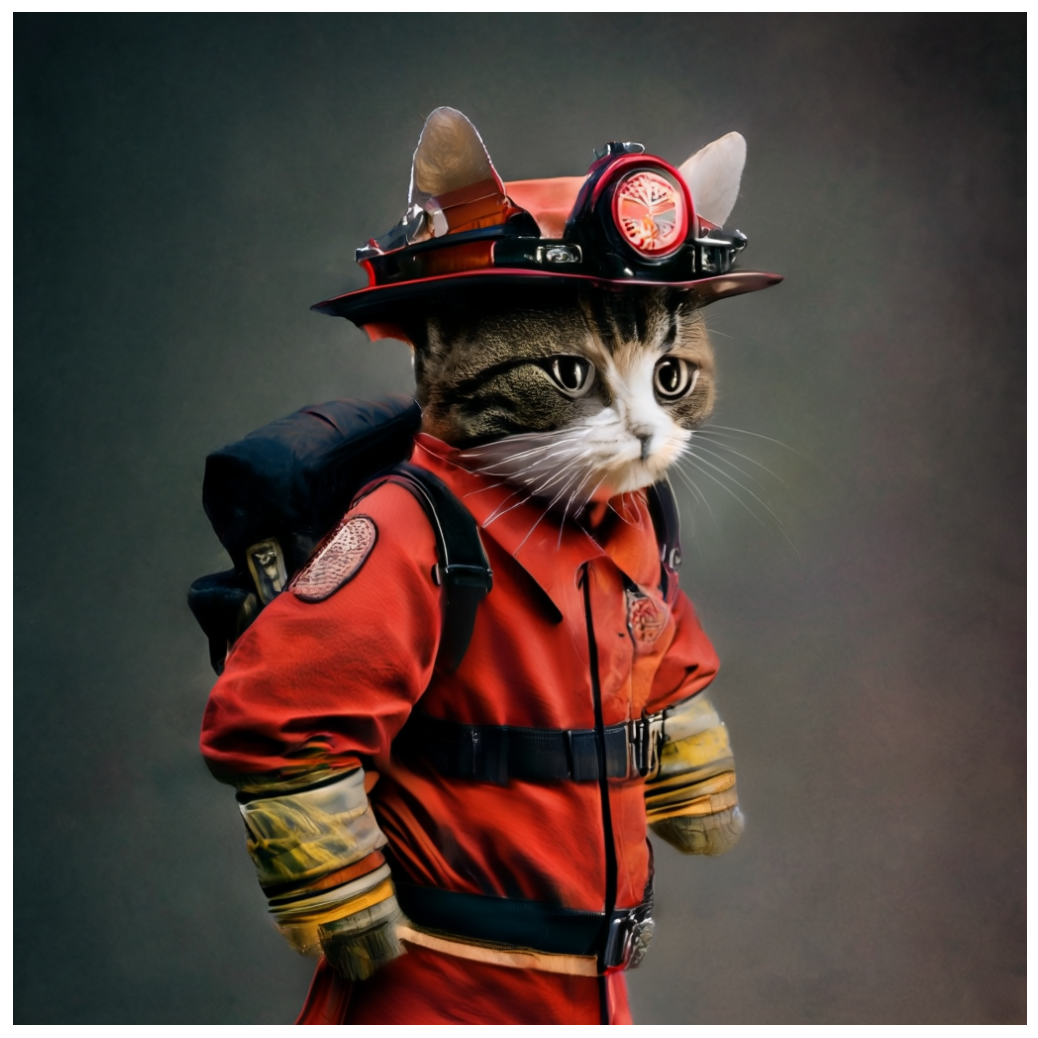

In [32]:
plt.figure(figsize=(8 * len(output), 8), dpi=128, layout="compressed")
for i, x in enumerate(output):
    plt.subplot(1, len(output), i + 1)
    plt.imshow(x)
    plt.axis("off")

## Interactive inference [$\Uparrow$](#Table-of-content:)


In [33]:
def generate(caption, negative_prompt, prior_guidance_scale, seed):
    generator = torch.Generator().manual_seed(seed)
    image = ov_pipe(
        prompt=caption,
        height=1024,
        width=1024,
        negative_prompt=negative_prompt,
        prior_num_inference_steps=30,
        prior_guidance_scale=prior_guidance_scale,
        num_images_per_prompt=1,
        generator=generator,
        output_type="pil",
    ).images[0]
    return image

In [34]:
demo = gr.Interface(
    generate,
    [
        gr.Textbox(label="Caption"),
        gr.Textbox(label="Negative prompt"),
        gr.Slider(2, 20, step=1, label="Prior guidance scale"),
        gr.Slider(0, np.iinfo(np.int32).max, label="Seed")
    ],
    "image",
    examples=[["Antropomorphic cat dressed as a firefighter", "", 4, 0]],
    allow_flagging="never",
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/